In [27]:
import sys
sys.path.append('../src')

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm
import pickle

from data import DataGeneratingProcess, SyntheticDataset
from models import MLP
from utils import set_seed, Trainer

In [2]:
class Continuum:
    def __init__(self, data, t_end, run_id):
        """Initialize with the sequences drawn from the process."""
        self.x = torch.from_numpy(data['x'][run_id]).float()
        self.y = torch.from_numpy(data['y'][run_id]).long()
        self.t = torch.from_numpy(data['t'][run_id]).float()
        self.present = 0
        self.t_end = t_end

    def __iter__(self):
        """Return the iterator object itself."""
        return self
    
    def __next__(self):
        """Return the next sample in the sequence or raise StopIteration."""
        if self.present >= self.t_end:
            raise StopIteration
        
        # get current sample
        x = self.x[self.present].unsqueeze(0)
        y = self.y[self.present]
        t = self.t[self.present]

        self.present += 1
        return x, y, t
    
    def get_test_loader_at_present(self):
        test_x = self.x[self.present:]
        test_y = self.y[self.present:]
        test_t = self.t[self.present:]
        test_data = TensorDataset(test_x, test_y, test_t)
        test_loader = DataLoader(
            test_data, 
            batch_size=100,
            shuffle=False
        )
        return test_loader

In [3]:
def evaluate(model, loader, device):
    perrs = []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]
            x, y, t = batch
            logits = model(x, t)
            probs = torch.softmax(logits, dim=1)
            err = (probs.argmax(dim=1) != y).float()
            perrs.append(err.cpu().numpy())
    perrs = np.concatenate(perrs)
    ploss = perrs.mean()
    return ploss

In [22]:
period = 20
t_end = 5000
seq_len = 10000
num_seeds = 3
dp = DataGeneratingProcess(period=period, seq_len=seq_len, num_seeds=3, 𝜆=-1, p=0.0)
dp.generate_data()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
methods = [
    {"name": "FTL", "is_prospective": False},
    {"name": "P-MLP", "is_prospective": True},
]

prospective_risk = {}
for method in methods:
    print(f"Evaluating {method['name']} ...")
    prospective_losses = []
    for rep in range(num_seeds):
        print(f"Rep {rep} ...")
        seed = 0
        acorn = seed * 1000 + 1996

        continuum = Continuum(dp.data, t_end=t_end, run_id=seed)
        progress_bar = tqdm(continuum, desc="Training", unit="t")

        model = MLP(prospective=method["is_prospective"])
        model.to(device)

        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=0.01,
            # momentum=0.9, 
            # nesterov=True,
            # weight_decay=0.00001
        )
        criterion = nn.CrossEntropyLoss()

        ploss_list = []
        for t_current, (x, y, t) in enumerate(progress_bar):
            model.eval()
            ploss = evaluate(model, continuum.get_test_loader_at_present(), device)
            ploss_list.append(ploss)

            model.train()
            logits = model(x, t)
            loss = criterion(logits.squeeze(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_description(f"Current Time [{t_current + 1}/{t_end}] - Loss: {loss.item():.3f} - Prosp. Loss: {ploss:.3f}")

        prospective_losses.append(ploss_list)
    prisk = np.stack(prospective_losses).mean(axis=0)
    prospective_risk[method["name"]] = prisk

Evaluating FTL ...
Rep 0 ...


Current Time [5000/5000] - Loss: 0.442 - Prosp. Loss: 0.493: : 5000t [03:35, 23.25t/s]


Rep 1 ...


Current Time [5000/5000] - Loss: 0.470 - Prosp. Loss: 0.493: : 5000t [03:30, 23.72t/s]


Rep 2 ...


Current Time [5000/5000] - Loss: 0.532 - Prosp. Loss: 0.493: : 5000t [03:34, 23.34t/s]


Evaluating P-MLP ...
Rep 0 ...


Current Time [5000/5000] - Loss: 0.089 - Prosp. Loss: 0.000: : 5000t [04:24, 18.90t/s]


Rep 1 ...


Current Time [5000/5000] - Loss: 0.060 - Prosp. Loss: 0.000: : 5000t [04:21, 19.10t/s]


Rep 2 ...


Current Time [5000/5000] - Loss: 0.055 - Prosp. Loss: 0.000: : 5000t [04:22, 19.07t/s]


In [ ]:
# save the results
with open(f"../results/online_pl_results.pkl", "wb") as f:
    pickle.dump({
        "prospective_risk": prospective_risk
    }, f)

### Plots

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(context='poster',
            style='ticks',
            font_scale=0.9,
            rc={'axes.grid':True,
                'grid.color':'.9',
                'grid.linewidth':0.75})

In [30]:
with open("../results/online_pl_results.pkl", "rb") as file:
    results = pickle.load(file)
prospective_risk = results['prospective_risk']

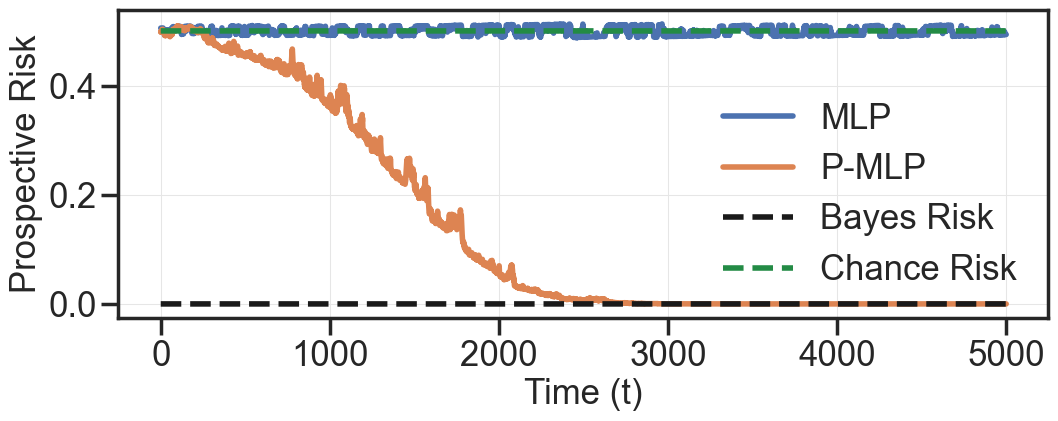

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))

lw = 4
fontsize = 25

online_t_list = np.arange(t_end)

ax.plot(online_t_list, prospective_risk['FTL'], label="MLP", lw=lw)
ax.plot(online_t_list, prospective_risk['P-MLP'], label="P-MLP", lw=lw)

ax.plot(online_t_list, np.zeros_like(online_t_list), lw=lw, ls='dashed', color='k', label="Bayes Risk")
ax.plot(online_t_list, 0.5*np.ones_like(online_t_list), lw=lw, ls='dashed', color='#238b45', label="Chance Risk")

ax.tick_params(axis='both', labelsize=fontsize)

ax.set_xlabel("Time (t)", fontsize=fontsize)
ax.set_ylabel("Prospective Risk", fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.savefig(f"../figures/5_online_training.pdf", bbox_inches='tight')
plt.show()